# Ch 4. Statistical Learning


We will use a set of exploratory features in consumer cedit files and develop a **credit scoring rule** to predict whether the loaner will be considered a good or bad client. 

1. Data Preparation
2. EDA
    - Cramer's V
3. Data Preprocessing
    - Normalization
    - One-hot encoding
    - Shuffle and split
4. Penalized Logistic Regression
    - Ridge
    - Lasso
6. Classification Tree 
7. Ensemble models
    - Bagging
    - Boosting
    - Random Forests



## 1. Data Preparation

This dataset is from Dr. Hans Hofmann of the University of Hamburg. (source: UCI Machine Learning Repository). 

In [49]:
# importing modules to be used
import numpy as np
import pandas as pd
import random
import scipy.stats as stats
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image
from __future__ import division

%matplotlib inline


In [2]:
credit = pd.read_table("Data/german.data.txt", 
                       delim_whitespace = True,
                       header = None)

colnames = ["checking_status", "duration", "credit_history", "purpose", "credit_amount",
           "savings", "employment", "installment_rate", "personal_status", "other_parties",
           "residence_since", "property_magnitude", "age", "other_payment_plans", "housing", 
           "existing_credits", "job", "num_dependents", "telephone", "foreign_workder", 
           "class"]

credit.columns = colnames
credit.head(10)

,checking_status,duration,credit_history,purpose,credit_amount,savings,employment,installment_rate,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,telephone,foreign_workder,class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
5,A14,36,A32,A46,9055,A65,A73,2,A93,A101,...,A124,35,A143,A153,1,A172,2,A192,A201,1
6,A14,24,A32,A42,2835,A63,A75,3,A93,A101,...,A122,53,A143,A152,1,A173,1,A191,A201,1
7,A12,36,A32,A41,6948,A61,A73,2,A93,A101,...,A123,35,A143,A151,1,A174,1,A192,A201,1
8,A14,12,A32,A43,3059,A64,A74,2,A91,A101,...,A121,61,A143,A152,1,A172,1,A191,A201,1
9,A12,30,A34,A40,5234,A61,A71,4,A94,A101,...,A123,28,A143,A152,2,A174,1,A191,A201,2


In [3]:
n_records = credit.shape[0]

n_good = sum(credit['class'] == 1)
n_bad = sum(credit['class'] == 2)
greater_percent = (n_good / n_records) * 100

print ""
print "Total number of Observations: {}".format(n_records)
print "Individuals credit-worthy: {}".format(n_good)
print "Individuals not credit-worthy: {}".format(n_bad)
print "Percentage of credit-worthy clients: {:.2f}%".format(greater_percent)


Total number of Observations: 1000
Individuals credit-worthy: 700
Individuals not credit-worthy: 300
Percentage of credit-worthy clients: 70.00%


In [4]:
# Re-encoding outcome variable. Good : 0, Bad: 1
y = credit['class'] - 1

# Splitting data into features and target label 
X = credit.drop('class', axis = 1)

## 2. Exploratory Data Analysis
###  1) Factor variables - Cramer's V

** Cramer's V **(1946) measures the correlation between categorical variates. 

$$ V = \sqrt{\frac{\chi ^2}{n(k - 1)}} $$

where chi^2 is the statistics of Pearson's chi-squared test of independencies, `n` is the number of samples and `k` is the number of unique classes for the two variables, whichever less. In our case, `k - 1` is equal to 1 because we have two classes in  output variable. While most of the features are categorical, we have three continuous features, duration, age, and credit amount. For the moment, we are arbitrarily categorizing these continuous features only for the sake of exploratory analysis. 

In [5]:
credit.f = X.copy()
cont = ["duration", "age", "credit_amount"]

# 10 break points for each cont vars
breakpoints = credit.f[cont].quantile(np.linspace(0.0, 1.0, num = 10))

for v in cont:
    credit.f[v] = pd.cut(credit.f[v], bins=breakpoints[v].unique())



In [6]:
feature_names = list(credit.f.columns)
cramer_v = np.zeros(len(feature_names))


for i, feature in enumerate(feature_names):
    cont = pd.crosstab(credit.f[feature], y)
    cramer_v[i] = np.sqrt(stats.chi2_contingency(cont)[0] * .001)
    
cramer_v = pd.Series(cramer_v, index = feature_names)

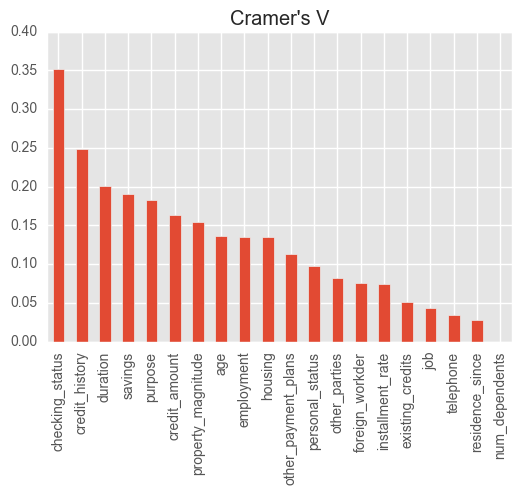

In [7]:
plt.style.use('ggplot')
cramer_v_sorted = cramer_v.sort_values(ascending = False)

plt.figure()
cramer_v_sorted.plot(kind = "bar")
plt.title("Cramer's V")


The sorted Cramer's V values for 20 features are shown above. It appears that the amount in existing checking account, credit history, and credit duration are moderately associated with the output label. It kind of alligns with our intuition in a sense that the more amount in the checking account and the longer credit history he has, the more likely he's a customer with good credit.   
  

# 3. Data Preprocessing 

## 1) Normalizing numerical features

Three continuouts features, duration, age, and credit amount, are normalized by minmaxscaler so that minimum value has 0 and maximum has 1.  

In [8]:
scaler = MinMaxScaler()
cont = ["duration", "age", "credit_amount"]
X[cont] = scaler.fit_transform(X[cont])
display(X[cont].describe())

,duration,age,credit_amount
count,1000.000000,1000.000000,1000.000000
mean,0.248574,0.295464,0.166241
std,0.177336,0.203133,0.155317
min,0.000000,0.000000,0.000000
25%,0.117647,0.142857,0.061379
50%,0.205882,0.250000,0.113871
75%,0.294118,0.410714,0.204812
max,1.000000,1.000000,1.000000


## 2) One-hot encoding

In [9]:
features = pd.get_dummies(X)
one_hot_encoded = list(features.columns)

print "{} total features after one-hot encoding.".format(len(one_hot_encoded))
print " "
print one_hot_encoded

61 total features after one-hot encoding.
 
['duration', 'credit_amount', 'installment_rate', 'residence_since', 'age', 'existing_credits', 'num_dependents', 'checking_status_A11', 'checking_status_A12', 'checking_status_A13', 'checking_status_A14', 'credit_history_A30', 'credit_history_A31', 'credit_history_A32', 'credit_history_A33', 'credit_history_A34', 'purpose_A40', 'purpose_A41', 'purpose_A410', 'purpose_A42', 'purpose_A43', 'purpose_A44', 'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49', 'savings_A61', 'savings_A62', 'savings_A63', 'savings_A64', 'savings_A65', 'employment_A71', 'employment_A72', 'employment_A73', 'employment_A74', 'employment_A75', 'personal_status_A91', 'personal_status_A92', 'personal_status_A93', 'personal_status_A94', 'other_parties_A101', 'other_parties_A102', 'other_parties_A103', 'property_magnitude_A121', 'property_magnitude_A122', 'property_magnitude_A123', 'property_magnitude_A124', 'other_payment_plans_A141', 'other_payment_plans_A142', 'o

## 3) Shuffle and split data


In [10]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, y,
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 800 samples.
Testing set has 200 samples.


# 4. Penalized Logistic Regression 

Logistic regression is now the most widely used method in credit scoring. 


## 1) Inference in the logistic model



## 2) Ridge model and Lasso Regression


$$ \hat{\beta(\lambda)} = argmin [ -logL(\beta;y,X) + \frac{\lambda}{n}p(\beta)] $$

$$ p(\beta) = \frac{1 - \alpha}{2} \sum _{k} \beta ^2 _k + \alpha \sum _{k} |\beta_k| $$

where we obtain ridge model when \alpha = 0 (L2 norm) and a lasso model when \alpha = 1 (L1 norm).  

#### Hyperparameter tuning via GridSearch

In [18]:
c_range = 10 ** np.linspace(-4, 4, 100)
gs = GridSearchCV(estimator = LogisticRegression(random_state = 42),
                 param_grid = [{'C': c_range,
                               'penalty': ['l1', 'l2']}], 
                 scoring = 'roc_auc',
                 cv = 10)
gs = gs.fit(X_train, y_train)

print("Train AUC:      %.4f" %gs.best_score_)
print("Optimal C value:      %.4f" %gs.best_params_['C'])
print "Best estiamtor selected: "
gs.best_estimator_

Train AUC:      0.7745
Optimal C value:      0.9112
Best estiamtor selected: 


LogisticRegression(C=0.91116275611548958, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Gridsearch shows that Lasso achieved highest AUC score at C = 0.9112.  


Let's comapare two penalty scheme by visualizing the area under the ROC curve scores against the parameter C.  

In [19]:
lasso_std_test_score = gs.cv_results_['std_test_score'][::2]
ridge_std_test_score = gs.cv_results_['std_test_score'][1::2]
lasso_mean_test_score = gs.cv_results_['mean_test_score'][::2]
ridge_mean_test_score = gs.cv_results_['mean_test_score'][1::2]
d = {'c_range': c_range,
    'lasso_mean': lasso_mean_test_score,
    'ridge_mean': ridge_mean_test_score,
    'lasso_std': lasso_std_test_score,
    'ridge_std': ridge_std_test_score,}
df = pd.DataFrame(d)
df.head(10)

,c_range,lasso_mean,lasso_std,ridge_mean,ridge_std
0,0.000100,0.5,0.0,0.516080,0.037293
1,0.000120,0.5,0.0,0.518234,0.037568
2,0.000145,0.5,0.0,0.520763,0.037525
3,0.000175,0.5,0.0,0.524099,0.038618
4,0.000210,0.5,0.0,0.528699,0.038320
5,0.000254,0.5,0.0,0.534419,0.037994
6,0.000305,0.5,0.0,0.539613,0.037660
7,0.000368,0.5,0.0,0.546201,0.037814
8,0.000443,0.5,0.0,0.556207,0.038436
9,0.000534,0.5,0.0,0.565860,0.038979


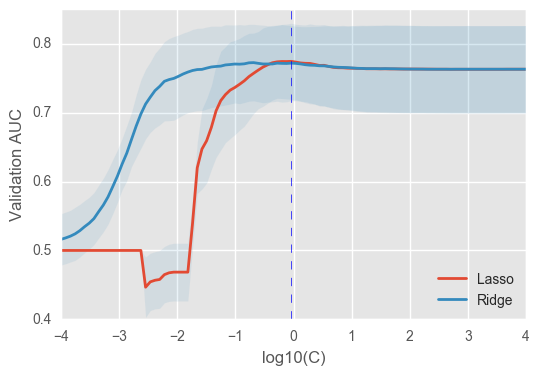

In [20]:
plt.plot(np.linspace(-4, 4, 100), df['lasso_mean'], 
         label = "Lasso", linewidth = 2)
plt.plot(np.linspace(-4, 4, 100), df['ridge_mean'],
        label = "Ridge", linewidth = 2)
plt.fill_between(np.linspace(-4, 4, 100), 
                 df['lasso_mean'] + df['lasso_std'], 
                 df['lasso_mean'] - df['lasso_std'],
                alpha = .1)
plt.fill_between(np.linspace(-4, 4, 100), 
                 df['ridge_mean'] + df['ridge_std'], 
                 df['ridge_mean'] - df['ridge_std'],
                alpha = .1)
plt.axvline(x = np.log10(gs.best_params_['C']), 
            linestyle = "--", linewidth = 0.5)
plt.xlabel("log10(C)")
plt.ylabel("Validation AUC")
plt.legend(loc = "lower right")


#### Hypothesis test on coefficient estimate

The method from scikit learn does not output p-values and confidence intervals. We will build a bootstrap to estimate the confidence interval of coefficients. 

In [50]:
lr_best = gs.best_estimator_
lr_best.fit(X_train, y_train)
coef_estimate = lr_best.coef_


n_obs = len(X_train)
n_bs = 10000
n_features = 61
bs_coef = np.zeros((61, 10000))

np.random.seed(42)
for n in xrange(n_bs):
    resampled_id = np.random.choice(X_train.index, len(X_train.index), replace = True)
    resampled_X_train = X_train.ix[resampled_id]
    resampled_y_train = y_train.ix[resampled_id]
    (clone(lr_best)).fit(resampled_X_train, resampled_y_train)
    bs_coef[:, n] = lr_best.coef_


In [23]:
bs_coef = pd.DataFrame(bs_coef)
bs_coef.index = list(features.columns)
bs_mean = bs_coef.mean(axis = 1)
bs_std = bs_coef.std(axis = 1) / np.sqrt(n_bs)
z = (coef_estimate[0] - bs_mean) / bs_std
p = 2 * (1 - stats.norm.cdf(abs(z)))

res = {'estimate': coef_estimate[0], 'mean': bs_mean, 'se': bs_std, 
       'z': z, 'p': p}

res = pd.DataFrame(res)
res = res.sort_values('p')

In [24]:
res

,estimate,mean,p,se,z
duration,1.296303,1.384819,0.000000e+00,0.007249,-12.211345
savings_A64,-0.369766,-0.530436,0.000000e+00,0.004946,32.481818
employment_A71,0.000000,0.121830,0.000000e+00,0.003033,-40.173172
employment_A72,0.000000,0.057716,0.000000e+00,0.001807,-31.946768
employment_A73,0.000000,0.051052,0.000000e+00,0.001428,-35.758397
personal_status_A92,0.000000,-0.048835,0.000000e+00,0.001589,30.726306
personal_status_A93,-0.451125,-0.532255,0.000000e+00,0.002420,33.521858
personal_status_A94,0.000000,-0.069330,0.000000e+00,0.001958,35.405897
other_parties_A101,0.000000,0.021451,0.000000e+00,0.001213,-17.686429
other_parties_A102,0.000000,0.066139,0.000000e+00,0.002830,-23.370241


Looks like most of our coefficient estimates are reliable. 
To estimate the performance of the final logistic regression model, let's measure the accuracy with the independent test dataset.  

In [28]:
pred_prob = pd.DataFrame(lr_best.predict_proba(X_test)).iloc[:, 1]
y_hat = pred_prob > .5
score = accuracy_score(y_test, y_hat)
score

print ("Test accuracy:   %.4f" %score)

Test accuracy:   0.7750


# 5. Tree Model

In [297]:
tree = DecisionTreeClassifier(random_state = 42)
tree = tree.fit(X_train, y_train)
tree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

# 6. Ensemble Methods

## 1) Bagging

In [44]:
bag = BaggingClassifier(base_estimator = tree,
                       n_estimators = 500, 
                       max_samples = 1.,
                       max_features = 1.,
                       random_state = 42)

In [45]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
train_score = accuracy_score(y_train, y_train_pred)
test_score = accuracy_score(y_test, y_test_pred)

print ("Train accuracy:   %.4f" %train_score)
print ("Test accuracy:   %.4f" %test_score)

Train accuracy:   1.0000
Test accuracy:   0.8050


## 2) Boosting



In [46]:
ada = AdaBoostClassifier(base_estimator = tree, 
                        n_estimators = 500,
                        learning_rate = .1,
                        random_state = 42)
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
train_score = accuracy_score(y_train, y_train_pred)
test_score = accuracy_score(y_test, y_test_pred)

print ("Train accuracy:   %.4f" %train_score)
print ("Test accuracy:   %.4f" %test_score)

Train accuracy:   1.0000
Test accuracy:   0.7350


## 3) Random forest


In [47]:
rf = RandomForestClassifier(random_state = 42,
                           n_estimators = 500)
rf = rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
train_score = accuracy_score(y_train, y_train_pred)
test_score = accuracy_score(y_test, y_test_pred)

print ("Train accuracy:   %.4f" %train_score)
print ("Test accuracy:   %.4f" %test_score)

Train accuracy:   1.0000
Test accuracy:   0.8000
